## Requirements

In [1]:
!pip install -q roboflow diffusers transformers accelerate wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 7.4 

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("arked").project("white-facade")
dataset = project.version(4).download("yolov7")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to White-Facade-4 in yolov7pytorch:: 100%|██████████| 79/79 [00:00<00:00, 2136.41it/s]


## Import and preprocessing

In [3]:
"""Module providing a functions to set the seed."""
import random
import torch
import numpy as np
import cv2

def set_random_seed(random_seed: int = 42) -> None:
    """Set the random seed for reproducibility. The seed is set for the
    random library, the numpy library and the OpenCV ansìd pytorch
    libraries.

    Parameters
    ----------
    random_seed : int, optional
        The random seed to use for reproducibility, by default 42.
    """
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    cv2.setRNGSeed(random_seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

RANDOM_STATE = 2808
set_random_seed(RANDOM_STATE)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.path as path
import numpy as np
import os
import cv2

# Function to parse the text label and extract polygon information
def parse_labels(label_file):
    with open(label_file, 'r') as file:
        lines = file.readlines()

    polygons = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            class_id = int(parts[0])
            coordinates = [float(coord) for coord in parts[1:]]
            num_points = len(coordinates) // 2  # Number of (x, y) pairs
            polygon = [(coordinates[i], coordinates[i + 1]) for i in range(0, len(coordinates), 2)]
            polygons.append((class_id, polygon))

    return polygons

# Function to plot bounding boxes
def plot_polygons(image_path, polygons):
    # Load the image if needed
    image = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots(1)

    # Generate unique colors for classes
    class_ids = set([class_id for class_id, _ in polygons])
    num_classes = len(class_ids)
    colors = generate_colors(num_classes)

    # Plot each polygon
    for class_id, polygon in polygons:
        x, y = zip(*polygon)
        color = colors[class_id % num_classes]
        polygon = plt.Polygon(np.c_[x, y], linewidth=1, edgecolor=color, facecolor='none', label=f'Class {class_id}')
        ax.add_patch(polygon)

    # Display the image
    ax.imshow(image)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # ax.legend()

    # Show the plot
    plt.show()

# Function to generate unique colors based on class ID
def generate_colors(num_classes):
    colormap = plt.cm.get_cmap('tab20', num_classes)
    colors = [colormap(i) for i in range(num_classes)]
    return colors

# Function to scale polygons to match an image size
def scale_polygons(polygons, image_size):
    scaled_polygons = []

    for class_id, polygon in polygons:
        # Scale the polygon coordinates
        scaled_polygon = [(x * image_size[0], y * image_size[1]) for x, y in polygon]
        scaled_polygons.append((class_id, scaled_polygon))

    return scaled_polygons


def enlarge_mask(mask, scaling_pixels=1):
    enlarged_mask = mask.copy()

    for s in range(1, scaling_pixels+1):
        # Create masks for shifting in all four directions
        up_mask = np.roll(mask, s, axis=0)
        down_mask = np.roll(mask, -s, axis=0)
        left_mask = np.roll(mask, s, axis=1)
        right_mask = np.roll(mask, -s, axis=1)

        # Use logical OR to combine the shifted masks
        enlarged_mask = np.logical_or(enlarged_mask, up_mask)
        enlarged_mask = np.logical_or(enlarged_mask, down_mask)
        enlarged_mask = np.logical_or(enlarged_mask, left_mask)
        enlarged_mask = np.logical_or(enlarged_mask, right_mask)

    return enlarged_mask.astype(np.uint8)

# generate mask from polygons
def generate_masks(polygons, image_size, label, num_samples=1, scaling_pixels=None):
    mask = np.zeros(image_size, dtype=np.uint8)

    i=0
    for class_id, polygon in polygons:
        if (class_id == label):
            x, y = zip(*polygon)
            # Create a Path object from the polygon coordinates
            path_polygon = path.Path(list(zip(x, y)))

            # Generate a mask for the polygon
            x, y = np.meshgrid(np.arange(image_size[0]), np.arange(image_size[1]))
            x, y = x.flatten(), y.flatten()
            points = np.vstack((x, y)).T
            mask_indices = path_polygon.contains_points(points).reshape(image_size[0], image_size[1])
            # Fill the polygon in the mask
            mask[mask_indices] = 1

            i+=1
            if (i == num_samples):
                break

    if scaling_pixels:
        mask = enlarge_mask(mask, scaling_pixels)
        return mask
    return mask

def create_dataset(image_paths, label_paths, label, num_samples=1, resize_shape=None, scaling_pixels=None):
    images = []
    masks = []

    # list of all the images in the image folder
    images_names = os.listdir(image_paths)
    label_names = [image_name.replace(".jpg", ".txt") for image_name in images_names]
    for img_name, label_name in zip(images_names, label_names):
        if (label_name not in os.listdir(label_paths)):
            images_names.remove(img_name)
            label_names.remove(label_name)
        img_path = image_paths + img_name
        label_path = label_paths + label_name

        # read the rgb image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_size = (img.shape[0], img.shape[1])
        polygons = parse_labels(label_path)
        scaled_polygons = scale_polygons(polygons, image_size)
        mask = generate_masks(scaled_polygons, image_size, label=label, num_samples=num_samples, scaling_pixels=scaling_pixels)

        # resize the image
        if resize_shape is not None:
            img = cv2.resize(img, resize_shape, interpolation=cv2.INTER_AREA)
            mask = cv2.resize(mask, resize_shape, interpolation=cv2.INTER_AREA)

        if len(np.unique(mask)) > 1:
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# mask the images with the masks
def mask_images(images, masks, invert=False):
    masked_images = []
    for img, mask in zip(images, masks):
        if invert:
            masked_images.append(img * (1 - mask[..., np.newaxis]))
        else:
            masked_images.append(img * mask[..., np.newaxis])
    return np.array(masked_images)

In [5]:
PATH = "White-Facade-4"

train_img_path = PATH + "/train/images/"
train_label_path = PATH + "/train/labels/"

In [6]:
# create the dataset
train_images, train_masks = create_dataset(train_img_path, train_label_path, label=0, num_samples=1)

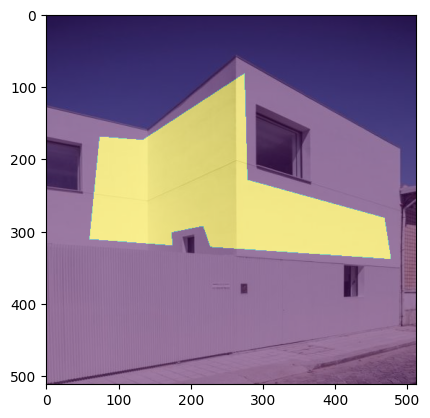

In [8]:
plt.imshow(train_images[0])
plt.imshow(train_masks[0], alpha=0.5)

## Dataset & Dataloader

In [ ]:
from diffusers import (
    AutoencoderKL,
    UNet2DConditionModel,
    DDIMScheduler,
    StableDiffusionPipeline,
)
from transformers import CLIPTextModel, CLIPTokenizer
from typing import List, Optional

def get_models(
    pretrained_model_name,
    pretrained_vae_name_or_path: Optional[str] = None,
    device: str = "cuda:0",
):

    tokenizer = CLIPTokenizer.from_pretrained(
        pretrained_model_name,
        subfolder="tokenizer",
    )

    text_encoder = CLIPTextModel.from_pretrained(
        pretrained_model_name,
        subfolder="text_encoder",
    )

    placeholder_token_ids = []

    vae = AutoencoderKL.from_pretrained(
        pretrained_vae_name_or_path or pretrained_model_name,
        subfolder=None if pretrained_vae_name_or_path else "vae",
    )
    unet = UNet2DConditionModel.from_pretrained(
        pretrained_model_name,
        subfolder="unet",
    )

    return (
        text_encoder.to(device),
        vae.to(device),
        unet.to(device),
        tokenizer,
        placeholder_token_ids,
    )

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import random
from pathlib import Path
from typing import Optional

class InpaintLoraDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        tokenizer,
        label: int,
        global_caption: str,
        token_map: Optional[dict] = None,
        size=512,
        h_flip=True,
        resize=True,
        normalize=True,
        blur_amount: int = 70,
        scaling_pixels: int = 0,
        train_inpainting: bool = True,
    ):
        self.size = size
        self.tokenizer = tokenizer
        self.resize = resize
        self.train_inpainting = train_inpainting

        if not Path(instance_data_root).exists():
            raise ValueError("Instance images root doesn't exists.")
        img_path = instance_data_root + "images/"
        label_path = instance_data_root + "labels/"

        # Prepare the instance images and masks
        self.imgs, self.masks = create_dataset(img_path, label_path, label, num_samples=2, scaling_pixels=scaling_pixels)
        self.global_captions = global_caption

        self.token_map = token_map

        self._length = len(self.imgs)

        self.h_flip = h_flip
        self.image_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                )
                if resize
                else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
                if normalize
                else transforms.Lambda(lambda x: x),
            ]
        )
        self.mask_transforms = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize(
                    size, interpolation=transforms.InterpolationMode.BILINEAR
                )
                if resize
                else transforms.Lambda(lambda x: x),
                transforms.CenterCrop(size),
                transforms.PILToTensor()
            ]
        )

        self.blur_amount = blur_amount

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}

        if self.train_inpainting:
            example["instance_masks"] = self.masks[index]
            example["instance_masked_images"] = mask_images(self.imgs[index], example["instance_masks"], invert=True)
            example["instance_masked_values"] = mask_images(self.imgs[index], example["instance_masks"], invert=False)

        example["instance_images"] = self.image_transforms(self.imgs[index])
        example["instance_masked_images"] = self.image_transforms(example["instance_masked_images"])
        example["instance_masked_values"] = self.image_transforms(example["instance_masked_values"])
        example["instance_masks"] = self.mask_transforms(example["instance_masks"])

        """
        if self.use_template:
            assert self.token_map is not None
            input_tok = list(self.token_map.values())[0]

            text = random.choice(self.templates).format(input_tok)
        else:
            text = self.global_captions[index].strip()

            if self.token_map is not None: # TODO implement this
                for token, value in self.token_map.items():
                    text = text.replace(token, value)
        """

        text = self.global_captions.strip()

        if self.h_flip and random.random() > 0.5:
            hflip = transforms.RandomHorizontalFlip(p=1)

            example["instance_images"] = hflip(example["instance_images"])
            example["instance_masked_images"] = hflip(example["instance_masked_images"])
            example["instance_masked_values"] = hflip(example["instance_masked_values"])
            example["instance_masks"] = hflip(example["instance_masks"])

        example["instance_prompt_ids"] = self.tokenizer(
            text,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        return example

In [ ]:
def inpainting_dataloader(
    dataset, batch_size, tokenizer
):
    def collate_fn(examples):
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]
        mask_values = [example["instance_masked_values"] for example in examples]
        masked_image_values = [
            example["instance_masked_images"] for example in examples
        ]
        mask = [example["instance_masks"] for example in examples]

        # Concat class and instance examples for prior preservation.
        # We do this to avoid doing two forward passes.
        if examples[0].get("class_prompt_ids", None) is not None:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]
            mask_values += [example["class_masks"] for example in examples]
            masked_image_values += [
                example["class_masked_images"] for example in examples
            ]

        pixel_values = (
            torch.stack(pixel_values).to(memory_format=torch.contiguous_format).float()
        )
        mask_values = (
            torch.stack(mask_values).to(memory_format=torch.contiguous_format).float()
        )
        masked_image_values = (
            torch.stack(masked_image_values).to(memory_format=torch.contiguous_format).float()
        )
        mask = (
            torch.stack(mask).to(memory_format=torch.contiguous_format).float()
        )

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            max_length=tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
            "mask_values": mask_values,
            "masked_image_values": masked_image_values,
            "mask": mask,
        }

        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    return train_dataloader

## Model

In [ ]:
train_label = 0
pretrained_model_name = "stabilityai/stable-diffusion-2-inpainting"

In [ ]:
text_encoder, vae, unet, tokenizer, placeholder_token_ids = get_models(
    pretrained_model_name,
    device="cuda:0",
)

In [ ]:
noise_scheduler = DDIMScheduler.from_pretrained(
    pretrained_model_name, subfolder="scheduler"
)

In [ ]:
global_caption = 'whiteFacade'

In [ ]:
train_dataset = InpaintLoraDataset(
    instance_data_root= PATH+"/train/",
    tokenizer=tokenizer,
    label=train_label,
    global_caption=global_caption,
    token_map=None,
    size=512,
    h_flip=False,
    resize=True,
    normalize=True,
    blur_amount=70,
    scaling_pixels=4,
)

In [ ]:
valid_dataset = InpaintLoraDataset(
    instance_data_root=PATH+"/valid/",
    tokenizer=tokenizer,
    label=train_label,
    global_caption=global_caption,
    token_map=None,
    size=512,
    h_flip=False,
    resize=True,
    normalize=False,
    blur_amount=70,
    scaling_pixels=4,
)

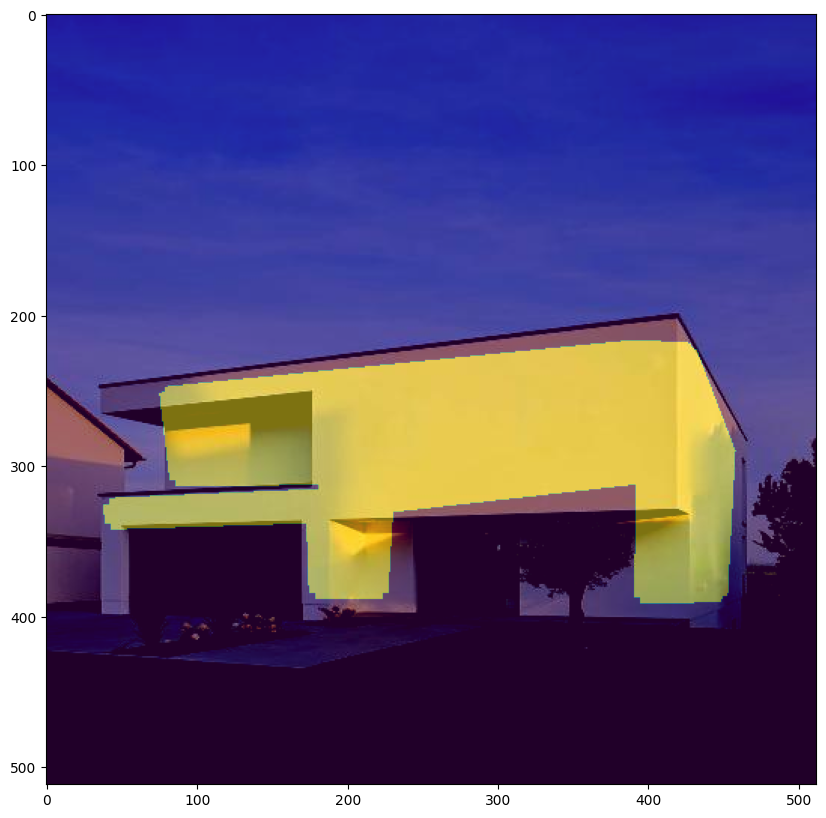

In [ ]:
example = train_dataset[1]

# plot the mask on the image
plt.figure(figsize=(10, 10))
plt.imshow(example["instance_images"].permute(1, 2, 0))
plt.imshow(example["instance_masks"].permute(1, 2, 0), alpha=0.5)
plt.show()

In [ ]:
train_batch_size=2
valid_batch_size=1

train_dataloader = inpainting_dataloader(
    train_dataset, batch_size=train_batch_size, tokenizer=tokenizer
)
valid_dataloader = inpainting_dataloader(
    valid_dataset, batch_size=valid_batch_size, tokenizer=tokenizer
)

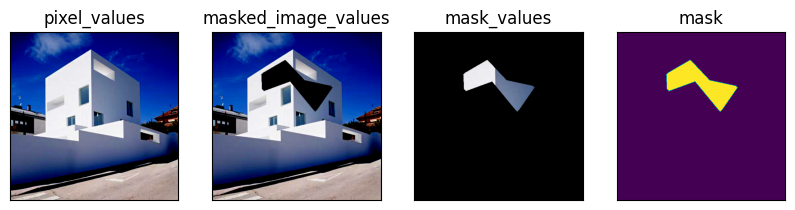

In [ ]:
batch = next(iter(train_dataloader))

# plot the batch
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.title("pixel_values")
plt.imshow(batch["pixel_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 2)
plt.title("masked_image_values")
plt.imshow(batch["masked_image_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 3)
plt.title("mask_values")
plt.imshow(batch["mask_values"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(batch["mask"][0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

## Training

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.checkpoint

def loss_step(
    batch,
    unet,
    vae,
    text_encoder,
    scheduler,
    t_mutliplier=1.0,
    mixed_precision=False,
    mask_temperature=1.0,
    vae_scale_factor=8,
):
    weight_dtype = torch.float32

    # encode the image
    latents = vae.encode(
            batch["pixel_values"].to(dtype=weight_dtype).to(unet.device)
        ).latent_dist.sample()


    # encode the masked image
    masked_image_latents = vae.encode(
                batch["masked_image_values"].to(dtype=weight_dtype).to(unet.device)
            ).latent_dist.sample()
    masked_image_latents = masked_image_latents * vae.config.scaling_factor
    latents = latents * vae.config.scaling_factor

    # scale the mask
    mask = F.interpolate(
                batch["mask"].to(dtype=weight_dtype).to(unet.device),
                scale_factor=1 / 8,
            )

    noise = torch.randn_like(latents)
    bsz = latents.shape[0]

    timesteps = torch.randint(
        0,
        int(scheduler.config.num_train_timesteps * t_mutliplier),
        (bsz,),
        device=latents.device,
    )
    timesteps = timesteps.long()

    noisy_latents = scheduler.add_noise(latents, noise, timesteps)

    latent_model_input = torch.cat(
            [noisy_latents, mask, masked_image_latents], dim=1
        )

    if mixed_precision:
        with torch.cuda.amp.autocast():

            encoder_hidden_states = text_encoder(
                batch["input_ids"].to(text_encoder.device)
            )[0]

            model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
    else:
        encoder_hidden_states = text_encoder(
            batch["input_ids"].to(text_encoder.device)
        )[0]

        model_pred = unet(latent_model_input, timesteps, encoder_hidden_states).sample
    if scheduler.config.prediction_type == "epsilon":
        target = noise
    elif scheduler.config.prediction_type == "v_prediction":
        target = scheduler.get_velocity(latents, noise, timesteps)
    else:
        raise ValueError(f"Unknown prediction type {scheduler.config.prediction_type}")

    if batch.get("mask", None) is not None:

        mask = (
            batch["mask"]
            .to(model_pred.device)
            .reshape(
                model_pred.shape[0], 1, model_pred.shape[2] * vae_scale_factor, model_pred.shape[3] * vae_scale_factor
            )
        )
        # resize to match model_pred
        mask = F.interpolate(
            mask.float(),
            size=model_pred.shape[-2:],
            mode="nearest",
        )

        mask = mask.pow(mask_temperature)

        mask = mask / mask.max()

        model_pred = model_pred * mask

        target = target * mask

    loss = (
        F.mse_loss(model_pred.float(), target.float(), reduction="none")
        .mean([1, 2, 3])
        .mean()
    )

    return loss

In [ ]:
from tqdm import tqdm
import itertools
from diffusers.utils.import_utils import is_xformers_available

weight_dtype = torch.float16

unet_lr = 2e-4
ti_lr = 1e-5
weight_decay_lora = 1e-4
weight_decay_ti = 1e-4
gradient_checkpointing = False
mixed_precision = False
use_xformers = True
train_lora = True
train_text_encoder = False
train_ti = False
clip_ti_decay = False # check well what this is doing

unet.requires_grad_(False)
vae.requires_grad_(False)
text_encoder.requires_grad_(False)

if gradient_checkpointing:
    unet.enable_gradient_checkpointing()

if use_xformers and is_xformers_available():
    unet.enable_xformers_memory_efficient_attention()

text_encoder_params = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)

if train_text_encoder:
    for param in text_encoder_params:
        param.requires_grad = True
else:
    for param in text_encoder_params:
        param.requires_grad = False

In [ ]:
from lora import inject_trainable_lora
from torch import optim
from torch.cuda import amp
from diffusers.optimization import get_scheduler

lora_unet_target_modules={"CrossAttention", "Attention", "GEGLU"}
lora_dropout_p = 0.1
lora_rank = 8
lora_scale = 1.0

unet_lora_params, _ = inject_trainable_lora(
    unet,
    r=lora_rank,
    target_replace_module=lora_unet_target_modules,
    dropout_p=lora_dropout_p,
    scale=lora_scale,
)

unet_params_to_optimize = [
    {"params": itertools.chain(*unet_lora_params), "lr": unet_lr},
]

if mixed_precision:
    scaler = torch.cuda.amp.GradScaler()

optimizer_lora = optim.AdamW(
    unet_params_to_optimize,
    lr=unet_lr,
    weight_decay=weight_decay_lora,
)

if train_ti:
    for p in text_encoder.get_input_embeddings().parameters():
        p.requires_grad_(True)
    optimizer_ti = optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),
        lr=ti_lr,
        weight_decay=weight_decay_ti,
    )

"""if mixed_precision:
    unet, optimizer = amp.initialize(unet, optimizer, opt_level="O1")"""

unet.train()
if train_text_encoder:
    text_encoder.train()

In [ ]:
sum(p.numel() for p in unet.parameters() if p.requires_grad)

2558464

In [ ]:
sum(p.numel() for p in text_encoder.parameters() if p.requires_grad)

0

In [ ]:
import wandb

wandb.login(key='')
wandb.init(project="inpainting-lora")

wandb.config.update(
    {
        "unet_lr": unet_lr,
        "text_encoder_lr": ti_lr,
        "weight_decay_lora": weight_decay_lora,
        "gradient_checkpointing": gradient_checkpointing,
        "mixed_precision": mixed_precision,
        "use_xformers": use_xformers,
        "train_text_encoder": train_text_encoder,
        "lr_warmup_steps": lr_warmup_steps,
        "max_train_steps": max_train_steps,
        "lora_unet_target_modules": lora_unet_target_modules,
        "lora_dropout_p": lora_dropout_p,
        "lora_rank": lora_rank,
        "lora_scale": lora_scale,
    }
)

wandb: Currently logged in as: maidacundo. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230920_201138-nwooj9ld
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run floral-rain-17
wandb: ⭐️ View project at https://wandb.ai/maidacundo/inpainting-lora
wandb: 🚀 View run at https://wandb.ai/maidacundo/inpainting-lora/runs/nwooj9ld


In [ ]:
placeholder_token_ids = tokenizer(global_caption).get('input_ids')

In [ ]:
index_no_updates = torch.arange(len(tokenizer)) != -1

for tok_id in placeholder_token_ids:
    index_no_updates[tok_id] = False

In [ ]:
import math
from tqdm import tqdm
from diffusers import StableDiffusionInpaintPipeline

# TODO parametrize

log_wandb = True
g_cuda = torch.Generator(device='cuda').manual_seed(2808)
mask_temperature = 1.0

num_steps = 10000
save_steps = len(train_dataset) * 3
lr_warmup_steps = 500
max_train_steps = 10000

lr_scheduler_lora = get_scheduler(
    "cosine",
    optimizer=optimizer_lora,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=max_train_steps,
)

if train_ti:
    lr_scheduler_ti = get_scheduler(
        "cosine",
        optimizer=optimizer_ti,
        num_warmup_steps=lr_warmup_steps,
        num_training_steps=max_train_steps,
    )

loss_sum = 0.0
progress_bar = tqdm(range(num_steps))
progress_bar.set_description("Steps")
global_step = 0

loss_sum_lora = 0.0
loss_sum_ti = 0.0

# initial log of generation, create a function
if 0 == 1:
    if log_wandb:
        with torch.no_grad():
            pipe = StableDiffusionInpaintPipeline(
                        vae=vae,
                        text_encoder=text_encoder,
                        tokenizer=tokenizer,
                        unet=unet,
                        scheduler=noise_scheduler,
                        safety_checker=None,
                        feature_extractor=None,
                    )
            examples = []
            # open all images in test_image_path
            prompt = global_caption
            for example in valid_dataset:

                image = example["instance_images"]
                mask_image = example["instance_masks"]

                generated_image = pipe(prompt=prompt,
                                        image=image,
                                        mask_image=mask_image,
                                        generator=g_cuda,
                                        num_inference_steps=20,
                                        height=image.shape[1],
                                        width=image.shape[2],
                                        negative_prompt='door, window'
                                        ).images[0]
                image = wandb.Image(generated_image)
                examples.append(image)
            wandb.log({"examples": examples})

# training

orig_embeds_params = text_encoder.get_input_embeddings().weight.data.clone()
index_updates = ~index_no_updates

for epoch in range(math.ceil(num_steps / len(train_dataloader))):
    for batch in train_dataloader:
        # TRAINING TEXTUAL INVERSION
        if train_ti:
            unet.eval()
            text_encoder.train()

            lr_scheduler_ti.step()
            optimizer_ti.zero_grad()

            loss_ti = loss_step(
                batch,
                unet,
                vae,
                text_encoder,
                noise_scheduler,
                t_mutliplier=0.8,
                mixed_precision=True,
                mask_temperature=mask_temperature,
            )
            loss_ti.backward()
            loss_sum_ti += loss_ti.detach().item()

            optimizer_ti.step()

            with torch.no_grad():
                # normalize embeddings
                if clip_ti_decay:
                    pre_norm = (
                        text_encoder.get_input_embeddings()
                        .weight[index_updates, :]
                        .norm(dim=-1, keepdim=True)
                    )

                    lambda_ = min(1.0, 100 * lr_scheduler_ti.get_last_lr()[0])
                    text_encoder.get_input_embeddings().weight[
                        index_updates
                    ] = F.normalize(
                        text_encoder.get_input_embeddings().weight[
                            index_updates, :
                        ],
                        dim=-1,
                    ) * (
                        pre_norm + lambda_ * (0.4 - pre_norm)
                    )

                current_norm = (
                    text_encoder.get_input_embeddings()
                    .weight[index_updates, :]
                    .norm(dim=-1)
                )

                text_encoder.get_input_embeddings().weight[
                    index_no_updates
                ] = orig_embeds_params[index_no_updates]

                logs_ti = {
                      "loss_ti": loss_ti.detach().item(),
                      "lr_ti": lr_scheduler_ti.get_last_lr()[0],
                      "current_norm_ti": current_norm
                  }
                progress_bar.set_postfix(**logs_ti)
                wandb.log(logs_ti)

        # TRAINING UNET LORA

        lr_scheduler_lora.step()

        optimizer_lora.zero_grad()

        loss_lora = loss_step(
            batch,
            unet,
            vae,
            text_encoder,
            noise_scheduler,
            t_mutliplier=0.8,
            mixed_precision=True,
            mask_temperature=mask_temperature,
        )
        loss_sum_lora += loss_lora.detach().item()

        loss_lora.backward()
        torch.nn.utils.clip_grad_norm_(
            itertools.chain(unet.parameters(), text_encoder.parameters()), 1.0
        )
        optimizer_lora.step()
        progress_bar.update(1)
        logs = {
            "loss_lora": loss_lora.detach().item(),
            "lr_lora": lr_scheduler_lora.get_last_lr()[0],
        }
        progress_bar.set_postfix(**logs)
        wandb.log(logs)

        global_step += 1

        if global_step % save_steps == 0:

            if log_wandb:
                with torch.no_grad():
                    pipe = StableDiffusionInpaintPipeline(
                                vae=vae,
                                text_encoder=text_encoder,
                                tokenizer=tokenizer,
                                unet=unet,
                                scheduler=noise_scheduler,
                                safety_checker=None,
                                feature_extractor=None,
                            )
                    examples = []
                    # open all images in test_image_path
                    prompt = 'white facade'
                    for example in valid_dataset:

                        image = example["instance_images"]
                        mask_image = example["instance_masks"]

                        generated_image = pipe(prompt=prompt,
                                               image=image,
                                               mask_image=mask_image,
                                               generator=g_cuda,
                                               num_inference_steps=20,
                                               height=image.shape[1],
                                               width=image.shape[2],
                                               negative_prompt='door, window'
                                               ).images[0]
                        image = wandb.Image(generated_image)
                        examples.append(image)
                    wandb.log({"examples": examples})
        if global_step >= num_steps:
            break


Steps:   0%|          | 36/10000 [01:49<8:24:58,  3.04s/it, loss_lora=0.0313, lr_lora=7.2e-5]

Steps:   1%|          | 99/10000 [02:33<4:18:45,  1.57s/it, loss_lora=0.011, lr_lora=3.96e-5] You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   2%|▏         | 198/10000 [05:27<4:18:46,  1.58s/it, loss_lora=0.0125, lr_lora=7.92e-5]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   3%|▎         | 297/10000 [08:21<4:13:45,  1.57s/it, loss_lora=0.00228, lr_lora=0.000119]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   4%|▍         | 396/10000 [11:14<4:06:00,  1.54s/it, loss_lora=0.0117, lr_lora=0.000158]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   5%|▍         | 495/10000 [14:08<3:55:53,  1.49s/it, loss_lora=0.0179, lr_lora=0.000198]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   6%|▌         | 594/10000 [17:02<4:08:29,  1.59s/it, loss_lora=0.013, lr_lora=0.0002]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   7%|▋         | 693/10000 [19:56<4:03:45,  1.57s/it, loss_lora=0.0167, lr_lora=0.0002]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   8%|▊         | 792/10000 [22:51<4:01:41,  1.57s/it, loss_lora=0.00491, lr_lora=0.0002]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:   9%|▉         | 891/10000 [25:45<3:59:31,  1.58s/it, loss_lora=0.00159, lr_lora=0.000199]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  10%|▉         | 990/10000 [28:39<3:52:39,  1.55s/it, loss_lora=0.0372, lr_lora=0.000199]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  11%|█         | 1089/10000 [31:33<3:34:25,  1.44s/it, loss_lora=0.00773, lr_lora=0.000198]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  12%|█▏        | 1188/10000 [34:27<3:51:29,  1.58s/it, loss_lora=0.00413, lr_lora=0.000197]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  13%|█▎        | 1287/10000 [37:22<3:51:16,  1.59s/it, loss_lora=0.0161, lr_lora=0.000197]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  14%|█▍        | 1386/10000 [40:16<3:47:01,  1.58s/it, loss_lora=0.0412, lr_lora=0.000196]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  15%|█▍        | 1485/10000 [43:10<3:40:38,  1.55s/it, loss_lora=0.0744, lr_lora=0.000195] You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  16%|█▌        | 1584/10000 [46:05<3:34:33,  1.53s/it, loss_lora=0.0107, lr_lora=0.000194] You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  17%|█▋        | 1683/10000 [48:59<3:13:57,  1.40s/it, loss_lora=0.00284, lr_lora=0.000192]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  18%|█▊        | 1782/10000 [51:54<3:37:53,  1.59s/it, loss_lora=0.00529, lr_lora=0.000191]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  19%|█▉        | 1881/10000 [54:48<3:32:48,  1.57s/it, loss_lora=0.00318, lr_lora=0.00019]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  20%|█▉        | 1980/10000 [57:42<3:30:55,  1.58s/it, loss_lora=0.00272, lr_lora=0.000188]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  21%|██        | 2079/10000 [1:00:36<3:24:39,  1.55s/it, loss_lora=0.0156, lr_lora=0.000187]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  22%|██▏       | 2178/10000 [1:03:31<3:15:34,  1.50s/it, loss_lora=0.00784, lr_lora=0.000185]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  23%|██▎       | 2277/10000 [1:06:26<3:24:42,  1.59s/it, loss_lora=0.0154, lr_lora=0.000183]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  24%|██▍       | 2376/10000 [1:09:21<3:24:14,  1.61s/it, loss_lora=0.0217, lr_lora=0.000181]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  25%|██▍       | 2475/10000 [1:12:15<3:19:42,  1.59s/it, loss_lora=0.00727, lr_lora=0.000179]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  26%|██▌       | 2574/10000 [1:15:09<3:15:12,  1.58s/it, loss_lora=0.0151, lr_lora=0.000177]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  27%|██▋       | 2673/10000 [1:18:04<3:07:39,  1.54s/it, loss_lora=0.00641, lr_lora=0.000175]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  28%|██▊       | 2772/10000 [1:20:58<2:55:05,  1.45s/it, loss_lora=0.0309, lr_lora=0.000173]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  29%|██▊       | 2871/10000 [1:23:53<3:09:29,  1.59s/it, loss_lora=0.0609, lr_lora=0.000171]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  30%|██▉       | 2970/10000 [1:26:47<3:04:52,  1.58s/it, loss_lora=0.00326, lr_lora=0.000168]You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_inpaint.StableDiffusionInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


Steps:  31%|███       | 3052/10000 [1:29:15<3:04:57,  1.60s/it, loss_lora=0.0128, lr_lora=0.000166]

In [ ]:
import os

import torch
from lora import (
    DEFAULT_TARGET_REPLACE,
    TEXT_ENCODER_DEFAULT_TARGET_REPLACE,
    UNET_DEFAULT_TARGET_REPLACE,
    convert_loras_to_safeloras_with_embeds,
    safetensors_available,
)

_target_by_name = {
    "unet": UNET_DEFAULT_TARGET_REPLACE,
    "text_encoder": TEXT_ENCODER_DEFAULT_TARGET_REPLACE,
}


def convert(*paths, outpath, overwrite=False, **settings):
    """
    Converts one or more pytorch Lora and/or Textual Embedding pytorch files
    into a safetensor file.

    Pass all the input paths as arguments. Whether they are Textual Embedding
    or Lora models will be auto-detected.

    For Lora models, their name will be taken from the path, i.e.
        "lora_weight.pt" => unet
        "lora_weight.text_encoder.pt" => text_encoder

    You can also set target_modules and/or rank by providing an argument prefixed
    by the name.

    So a complete example might be something like:

    ```
    python -m lora_diffusion.cli_pt_to_safetensors lora_weight.* --outpath lora_weight.safetensor --unet.rank 8
    ```
    """
    modelmap = {}
    embeds = {}

    if os.path.exists(outpath) and not overwrite:
        raise ValueError(
            f"Output path {outpath} already exists, and overwrite is not True"
        )

    for path in paths:
        data = torch.load(path)

        if isinstance(data, dict):
            print(f"Loading textual inversion embeds {data.keys()} from {path}")
            embeds.update(data)

        else:
            name_parts = os.path.split(path)[1].split(".")
            name = name_parts[-2] if len(name_parts) > 2 else "unet"

            model_settings = {
                "target_modules": _target_by_name.get(name, DEFAULT_TARGET_REPLACE),
                "rank": 4,
            }

            prefix = f"{name}."

            arg_settings = { k[len(prefix) :]: v for k, v in settings.items() if k.startswith(prefix) }
            model_settings = { **model_settings, **arg_settings }

            print(f"Loading Lora for {name} from {path} with settings {model_settings}")

            modelmap[name] = (
                path,
                model_settings["target_modules"],
                model_settings["rank"],
            )

    convert_loras_to_safeloras_with_embeds(modelmap, embeds, outpath)

In [ ]:
convert(['lora_weight.pt'], outpath='lora_weight.safetensor', overwrite=False, rank=8)

AttributeError: ignored

In [ ]:
path = 'lora_weight.pt'
data = torch.load(path)

In [ ]:
modelmap = {}
embeds = {}
target_replace_module_unet = {"CrossAttention", "Attention", "GEGLU"}

if isinstance(data, dict):
    print(f"Loading textual inversion embeds {data.keys()} from {path}")
    embeds.update(data)

else:
    name_parts = os.path.split(path)[1].split(".")
    name = name_parts[-2] if len(name_parts) > 2 else "unet"

    model_settings = {
        "target_modules": _target_by_name.get(name, DEFAULT_TARGET_REPLACE),
        "rank": 4,
    }

    prefix = f"{name}."

    print(f"Loading Lora for {name} from {path} with settings {model_settings}")

    modelmap[name] = (
        path,
        target_replace_module_unet,
        64,
    )

Loading Lora for unet from lora_weight.pt with settings {'target_modules': {'Attention', 'CrossAttention', 'GEGLU'}, 'rank': 4}


In [ ]:
convert_loras_to_safeloras_with_embeds(modelmap, embeds, 'lora_weight.safetensor')

Saving weights to lora_weight.safetensor


In [ ]:
from lora import save_lora_weight

save_path = "lora_inpainting.pt"
target_replace_module_unet = {"CrossAttention", "Attention", "GEGLU"}
save_lora_weight(
    unet, save_path, target_replace_module=target_replace_module_unet
)
print("Unet saved to ", save_path)

Unet saved to  lora_inpainting.pt


In [ ]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)

In [ ]:
test_dataset = InpaintLoraDataset(
    instance_data_root="Bounding-Boxes-3/test/",
    tokenizer=tokenizer,
    label=roof_label,
    global_caption="A roof",
    token_map=None,
    size=512,
    h_flip=False,
    color_jitter=False,
    resize=True,
    train_inpainting=True,
    blur_amount=70,
)

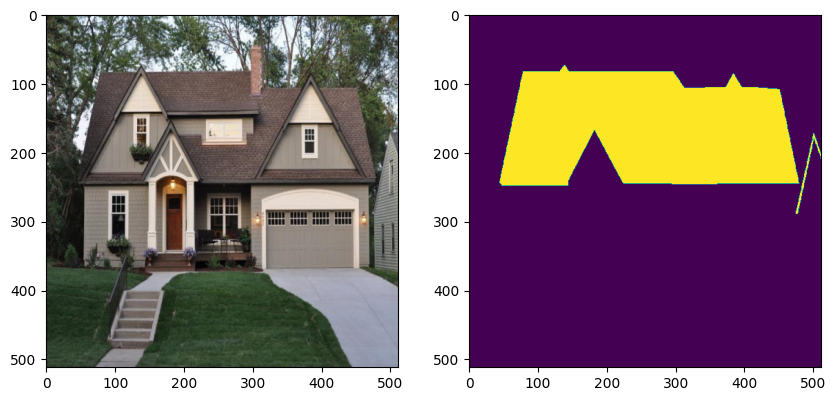

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(TRAIN[0]["instance_images"].permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(test_dataset[0]["instance_masks"].permute(1, 2, 0))
plt.show()

In [ ]:
prompt = 'A roof'
image = test_dataset[0]["instance_images"]
mask_image = test_dataset[0]["instance_masks"]

generated_image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]